# The Neighborhoods of Joensuu

 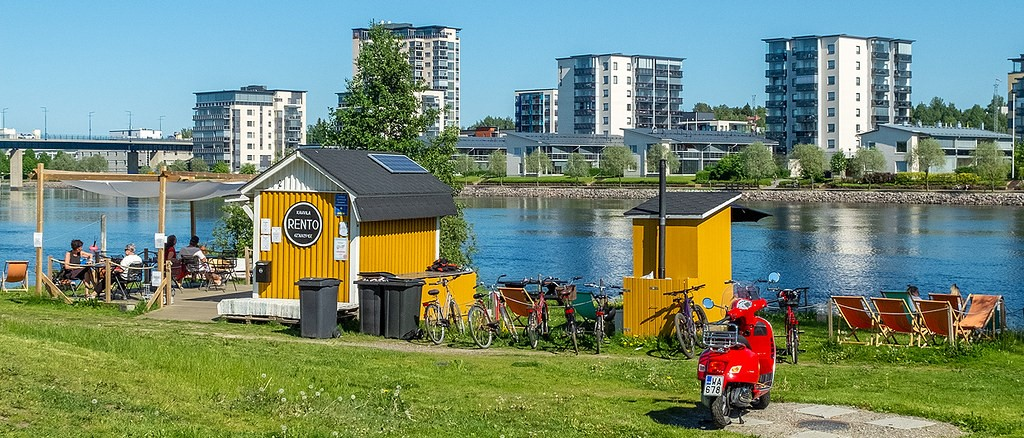

## Project Description
In previous assignments, it has been shown that Python packages may be used to highlight the key attractions of a city. The city I currently live in is Joensuu, Finland. Joensuu is a "college town" with two universities and a generally small population which means roughly 13% of the cities residents are students. This means that one of the largest (if not largest) providers of housing in the city is the student housing company, Elli. Elli maintains at least 40 different housing complexes across seven neighborhoods in the city. While most apartments are simply assigned as they become available from the waiting list, it is possible to request certain housing complexes. At this time, however, they provide only a little information about the complex/flat, and no information about the neighborhood or its proximity to key city features such as the City Center, and the universities.

My plan is to develop a tool that will be able to provide a "snapshot" of the neighborhoods in order to help Elli and its residents find better matches to their neighborhood wants and needs. I hope to achieve this by leveraging the FourSquare API to establish what kinds of features are most common in the neighborhoods as well as the distance that the neighborhood is from the key city features such as those already mentioned above. Further by applying machine learning it will be possible to suggeest how similar neighborhoods are to each other, in the case that Elli does not have availabilty in a tenants desired neighborhood.Aside from the FourSquare API providing information on the attractions, it will also be necessary to find location information for the neighborhoods and city features. Hopefully this data may be collected through scraping, howevere given the nature of Joensuu I believe this will have to be retreived manualy. Maps will ofcourse be necessary as well and are available from the folium package. Then the goal will be to present this information in well designed manner that is both attractive and easy to use.

## Data Collection
Unfortunately at this time I cannot find a good resource for scraping the coordinates for the desired locations in Joensuu. However, luckily the size of the city works to my advantage here as I only need to find location data for seven neighborhoods and three landmarks. It is my hope that in the future I can find a good resource for this information and update this work.

In [1]:
import pandas as pd
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
df_neighborhoods = pd.read_csv('Joensuu Neighborhoods.csv', sep = ';')
df_neighborhoods.head(7)

,Neighborhood,Latitude,Longitude
0,Keskusta,62.601284,29.763646
1,Niinivaara/Penttila,62.592993,29.786133
2,Etu-Noljakka,62.620141,29.709180
3,Taka-Noljakka,62.625705,29.695279
4,Rantakyla,62.616781,29.819066
5,Hukanhauta,62.585037,29.794735
6,Kanervala,62.612819,29.752171


To begin understanding how the city is laid out lets go ahead and quickly display the map

In [3]:
# create map of Joensuu using latitude and longitude values
location = [62.601284, 29.763646]
map_Joensuu = folium.Map(location=location, zoom_start=12)

# add neighborhoods to map
for lat, lng, neighborhood in zip(df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], df_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Joensuu)  
    
map_Joensuu

It wil probably help to go ahead and add the landmarks (University of Eastern Finland, Karelia University of Applied Sciences, and City Center) to the map. Again the coordinates and adresses are not readily available from anywhere that I yet know.

In [4]:
df_landmarks = pd.read_csv('Joensuu Landmarks.csv', sep = ';')
df_landmarks.head()

,Landmark,Latitude,Longitude
0,University of Eastern Finland,62.603969,29.747152
1,Karelia University of Applied Sciences,62.596527,29.777998
2,City Center,62.601284,29.763646


In [5]:
df_landmarks['Latitude'][0]

62.60396905583575

In [6]:
df_landmarks = pd.read_csv('Joensuu Landmarks.csv', sep = ';')

# add landmarks to map
for lat, lng, landmark in zip(df_landmarks['Latitude'], df_landmarks['Longitude'], df_landmarks['Landmark']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Joensuu)  
    
map_Joensuu

Now that we're starting to get an idea of where everything is lets start to find out fomelings about these neighborhoods. This is where we wil begin using the FourSquare API. To do this we must pass a url to FourSquare everytime we want something from it. This url includes not just my developer credentials, but also the query. Rather than type this out ever time I;ll build a function to do the heavy lifting for us.

In [7]:
CLIENT_ID = '3X0KKN3SR0RCL33BQT5LJMLAOBLF2VLCC4RCYV1PCB431FTY'
CLIENT_SECRET = 'ICFFX50MA3J0AXGFS0Y2OXMSG0JYB0BUPCNQ22VWTIXSPSTL'
ACCESS_TOKEN = 'EJL4UR44K0YVDQBD2MXFF04ANSWEVAWJ4IR5EUIH1Q01YPJU' 
VERSION = '20180604'
LIMIT = 30

Neighborhood_latitude = df_neighborhoods.loc[0, 'Latitude'] # Neighbourhood latitude value
Neighborhood_longitude = df_neighborhoods.loc[0, 'Longitude'] # Neighbourhood longitude value

Neighborhood_name = df_neighborhoods.loc[0, 'Neighborhood'] # Neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(Neighborhood_name, 
                                                               Neighborhood_latitude, 
                                                               Neighborhood_longitude))

LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Neighborhood_latitude, 
    Neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

Latitude and longitude values of Keskusta are 62.60128350395353, 29.76364569527613.


With the first set of data retrieved from FourSquare for Kaskusta, it is now time to start processing it to give characteristics of the neighborhood. We'll mostly be interested in what kinds of atractions (venues) the neighborhood has.

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

To speed things along lets add a function that will allow us to get the same information for the remaining neighborhoods, and then call it.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

df_venues = getNearbyVenues(names=df_neighborhoods['Neighborhood'],
                                   latitudes=df_neighborhoods['Latitude'],
                                   longitudes=df_neighborhoods['Longitude']
                                  )

Keskusta
Niinivaara/Penttila
Etu-Noljakka
Taka-Noljakka
Rantakyla
Hukanhauta
Kanervala


Joensuu is small but lets see how many unique types of attraction there are in the city.

In [11]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 40 uniques categories.


One hot encoding helps with (speeding up) the up coming machine learning step as it will ensure that all the data is numeric.

In [12]:
# one hot encoding
Joensuu_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Joensuu_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Joensuu_onehot.columns[-1]] + list(Joensuu_onehot.columns[:-1])
Joensuu_onehot = Joensuu_onehot[fixed_columns]

In [13]:
Joensuu_grouped = Joensuu_onehot.groupby('Neighborhood').mean().reset_index()
Joensuu_grouped

,Neighborhood,Arts & Crafts Store,Bar,Beer Bar,Boat or Ferry,Boutique,Bowling Alley,Café,Chinese Restaurant,Clothing Store,...,Rock Club,Sandwich Place,Scandinavian Restaurant,Shopping Mall,Soccer Field,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Supermarket,Zoo
0,Etu-Noljakka,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0
1,Hukanhauta,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.0
2,Kanervala,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0
3,Keskusta,0.02,0.06,0.02,0.02,0.02,0.02,0.08,0.04,0.02,...,0.02,0.02,0.04,0.02,0.0,0.02,0.02,0.04,0.06,0.0
4,Niinivaara/Penttila,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.2,0.00,0.00,0.00,0.20,0.0
5,Rantakyla,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.50,0.0
6,Taka-Noljakka,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.20,0.00,0.20,0.0,0.00,0.00,0.00,0.20,0.2


In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Joensuu_grouped['Neighborhood']

for ind in np.arange(Joensuu_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Joensuu_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Etu-Noljakka,Pizza Place,Arts & Crafts Store,Bar
1,Hukanhauta,Supermarket,Arts & Crafts Store,Restaurant
2,Kanervala,Hostel,Dog Run,Arts & Crafts Store
3,Keskusta,Café,Pizza Place,Supermarket
4,Niinivaara/Penttila,Medical Center,Supermarket,Soccer Field


At this point machine learning is used to identify how similar the neighborhoods are based on the frequency of the atractions. It does this by taking establishing the Euclidean distance from the data points, and then forming clusters based on proximity. I have asked for 3 clusters as I feel that this is appropriate for the number of neighborhoods.

In [15]:
# set number of clusters
kclusters = 3

Joensuu_grouped_clustering = Joensuu_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Joensuu_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 2, 2, 2, 0, 2], dtype=int32)

In [16]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Joensuu_merged = df_neighborhoods

# merge Joensuu_grouped with Joensuu_data to add latitude/longitude for each neighborhood
Joensuu_merged = Joensuu_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Joensuu_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Keskusta,62.601284,29.763646,2,Café,Pizza Place,Supermarket
1,Niinivaara/Penttila,62.592993,29.786133,2,Medical Center,Supermarket,Soccer Field
2,Etu-Noljakka,62.620141,29.709180,1,Pizza Place,Arts & Crafts Store,Bar
3,Taka-Noljakka,62.625705,29.695279,2,Zoo,Supermarket,Shopping Mall
4,Rantakyla,62.616781,29.819066,0,Supermarket,Park,Gym


In [17]:
# create map
map_clusters = folium.Map(location=location, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Joensuu_merged['Latitude'], Joensuu_merged['Longitude'], Joensuu_merged['Neighborhood'], Joensuu_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As mentioned in the problem overview I believe that it would also be beneficial for students choosing housing to understand how far they may be from specific places like the universities. In a city that can have temperatures of -30$^\circ$ C, this migh have an impact on where you want to live.

In [18]:
df_final = neighborhoods_venues_sorted
df_final.head(7)
df_final.drop('Cluster Labels', inplace = True, axis = 1)

In [19]:
!pip install geopy

In [20]:
import geopy.distance

# define the dataframe columns
column_names = ['Neighborhood', 'UEF', 'KUAS', 'City Center'] 

# instantiate the dataframe
distances = pd.DataFrame(columns=column_names)

for i in range(len(df_neighborhoods['Neighborhood'])):
    neighborhood_name = df_neighborhoods['Neighborhood'][i]
    
    coords_1 = (df_neighborhoods['Latitude'][i], df_neighborhoods['Longitude'][i])
    coords_2 = (df_landmarks['Latitude'][0], df_landmarks['Longitude'][0])
    d_UEF = geopy.distance.distance(coords_1, coords_2).km
    
    coords_3 = (df_neighborhoods['Latitude'][i], df_neighborhoods['Longitude'][i])
    coords_4 = (df_landmarks['Latitude'][1], df_landmarks['Longitude'][1])
    d_KUAS = geopy.distance.distance(coords_3, coords_4).km
    
    coords_5 = (df_neighborhoods['Latitude'][i], df_neighborhoods['Longitude'][i])
    coords_6 = (df_landmarks['Latitude'][2], df_landmarks['Longitude'][2])
    d_CC = geopy.distance.distance(coords_3, coords_4).km
    
    distances = distances.append({'Neighborhood': neighborhood_name,
                                  'UEF': d_UEF,
                                  'KUAS': d_KUAS,
                                  'City Center': d_CC,
                                  }, ignore_index=True)

In [21]:
df_final = pd.merge(df_final, distances, how='inner')

## Results

By collecting the data regarding the amenities that are near by each housing location we have been able to acheive 2 important results that may be important to both the leasing company Elli and their potential clients. First, both parties may now take advantage of knowing the types of businesses/activities which are comon in the neighborhood. The advantages to future tenants should be obvious. If it is important to the student that they have access to night life they now know that Etu-Noljakka has Pizza and Bars near by. On the other hand if a grad-student with a dog or family is looking for a quieter living condition they can focus on complexes in Kanervala. For Elli this helps them suggest locations to their tenants. Before moving on from the results presented in the table below is that for students either with mobility issues that need to live close to the school, or perhaps students who study best at home it is now possible for them to understand how far away from their campus orthe City Center the neighborhood is.

In [22]:
df_final.head(7)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,UEF,KUAS,City Center
0,Etu-Noljakka,Pizza Place,Arts & Crafts Store,Bar,2.655155,4.406246,4.406246
1,Hukanhauta,Supermarket,Arts & Crafts Store,Restaurant,3.229265,1.542531,1.542531
2,Kanervala,Hostel,Dog Run,Arts & Crafts Store,1.019446,2.248644,2.248644
3,Keskusta,Café,Pizza Place,Supermarket,0.898456,0.908059,0.908059
4,Niinivaara/Penttila,Medical Center,Supermarket,Soccer Field,2.346496,0.574284,0.574284
5,Rantakyla,Supermarket,Park,Gym,3.959042,3.089293,3.089293
6,Taka-Noljakka,Zoo,Supermarket,Shopping Mall,3.600201,5.349358,5.349358


The other key result of this work was been establishing the similarities that exist between neighborhoods. Again this is an important take away for Elli as it will allow them to find alternative neighborhoods for people who have spent long times on the waiting list by suggesting one similar.

In [23]:
map_clusters

One personally surprising result was to discover that Joensuu has a zoo. Over all these results illustrate the power of applying machine learning and to data that has been scraped from the internet. As well as the power for python packackes to execute this work in a reliable manor. 

## Original Assignment
Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve. If you cannot think of an idea or a problem, here are some ideas to get you started:

1. In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine this idea.
2. In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?

These are just a couple of many ideas and problems that can be solved using location data in addition to other datasets. No matter what you decide to do, make sure to provide sufficient justification of why you think what you want to do or solve is important and why would a client or a group of people be interested in your project.

### Review criteria

This capstone project will be graded by your peers. This capstone project is worth 70% of your total grade. The project will be completed over the course of 2 weeks.  Week 1 submissions will be worth 30% whereas week 2 submissions will be worth 40% of your total grade.

For this week, you will required to submit the following:

1. A description of the problem and a discussion of the background. (15 marks)
2. A description of the data and how it will be used to solve the problem. (15 marks)

For the second week, the final deliverables of the project will be:

1. A link to your Notebook on your Github repository, showing your code. (15 marks)
2. A full report consisting of all of the following components (15 marks):
   
* Introduction where you discuss the business problem and who would be interested in this project.
* Data where you describe the data that will be used to solve the problem and the source of the data.
* Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
* Results section where you discuss the results.
* Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

Conclusion section where you conclude the report.
3. Your choice of a presentation or blogpost. (10 marks)